# Binary Classification ML Model

# Import Libraries

Download the necessary libraries

In [2]:
# Data Manipulation and Visualization Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Odds Ratios and Variance Inflation Factor
import statsmodels.api as sm 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Data preprocessing and metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay, precision_recall_curve, average_precision_score

# ML models that will be used
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

# Used for hyperparameter tuning for XGBoost
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

# Used for feature importance for KNN
from sklearn.inspection import permutation_importance


In [3]:
# So that we can see all of the columns when working with the data frames (not necessary for this small dataset)
pd.set_option('display.max_columns', None)

## Load Dataset
This data set can be downloaded from Kaggle and moved to the same folder as the jupyter notebook you are working on

The Dataset comes from https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction

In [4]:
df = pd.read_csv("heart.csv")

## About the Data
- Age: age of the patient [years]
- Sex: sex of the patient [M: Male, F: Female]
- ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- RestingBP: resting blood pressure [mm Hg]
- Cholesterol: serum cholesterol [mm/dl]
- FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
- ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
- Oldpeak: oldpeak = ST [Numeric value measured in depression]
- ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- HeartDisease: output class [1: heart disease, 0: Normal]

In [5]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [7]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


## Value Counts for Categorical Data

In [8]:
for col in df.columns:
    if df[col].dtype == 'object':
        print(df[col].value_counts(dropna=False))
        print()

Sex
M    725
F    193
Name: count, dtype: int64

ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64

RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64

ExerciseAngina
N    547
Y    371
Name: count, dtype: int64

ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64



In [9]:
# Storing Categorical and Continuous Variables in lists to be referenced throughout the notebook
cat_vars = [
    'Sex',
    'ChestPainType',
    'RestingECG',
    'ExerciseAngina',
    'ST_Slope',
    'FastingBS' # Binary Variable (see 'About the Data' above)
]

num_vars = [
    'Age',
    'Cholesterol',
    'MaxHR',
    'Oldpeak',
    'RestingBP'
]

In [10]:
# Double checking that our categorical variables and numerical variables list covers all variables from our dataset
len(df.drop('HeartDisease', axis=1).columns)==len(cat_vars+num_vars)

True

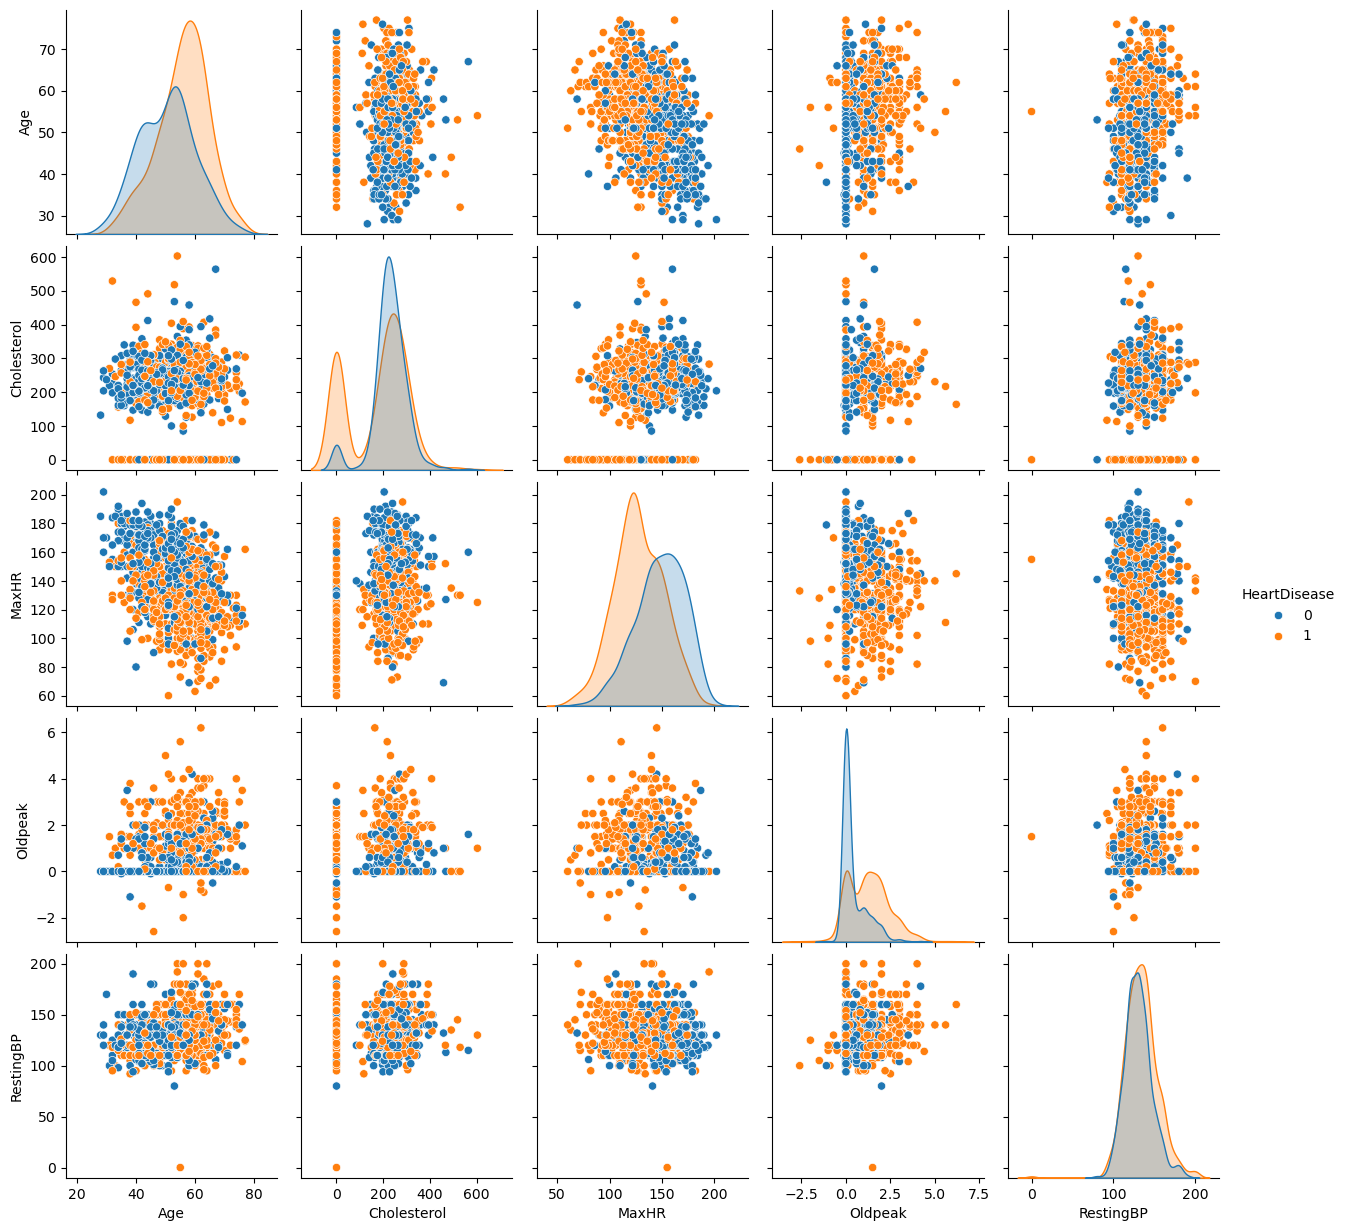

In [11]:
# Pairwise scatter plot that visualizes relationships between numerical variables in a dataset. 
# It plots each variable on both the x and y axes against every other variable, helping to identify trends, correlations, and distributions. 
# The diagonal plots represent the univariate distribution of each variable, in this case, shown as a Kernel Density Estimation (KDE) plot.
sns.pairplot(data=df, x_vars=num_vars, y_vars=num_vars, diag_kind='kde', hue='HeartDisease')

> I am noticing that out cholesterol feature has a significant amount of zero values (18%). I left them alone for now, but these values were most likely null and filled with a zero value. With future iterations of this notebook I will explore KNN Imputation for these zero cholesterol values.

In [12]:
# Ratio of zero values for Cholesterol
len(df[df['Cholesterol']==0])/len(df)

0.18736383442265794

## Multicolinearity
Steps:
- Compute a correlation matrix (visualized by a heatmap) and flag variables with an absolute correlation of greater than 0.7 for further investigation.
- Calculate the Variance Inflation Factor (VIF), flagging features with VIF of greater than 10.

### Correlation Matrix

Text(0.5, 1.0, 'Numeric Feature Correlation Map')

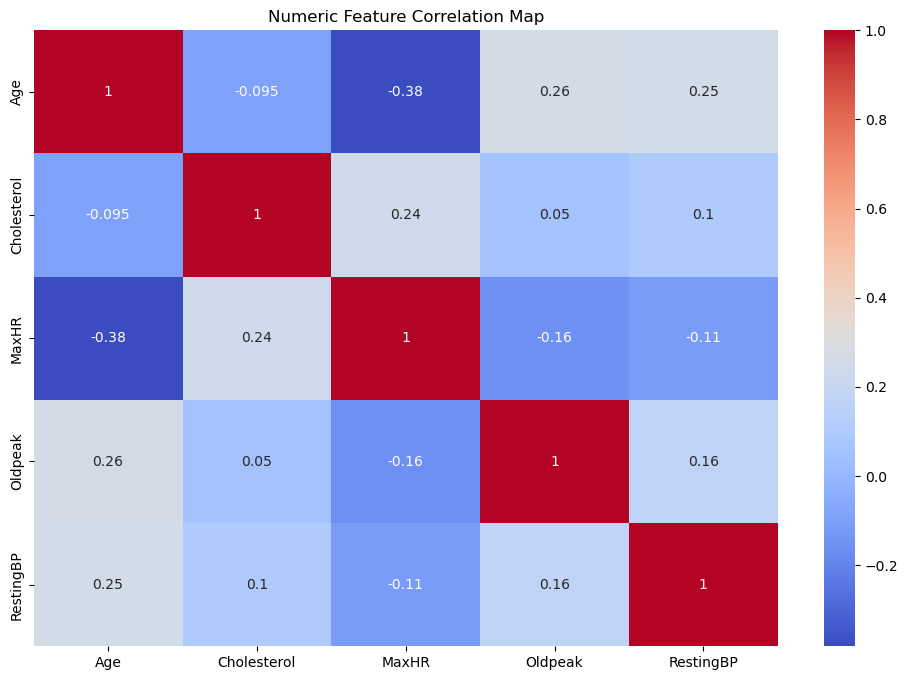

In [13]:
plt.figure(figsize=(12,8))
sns.heatmap(df[num_vars].corr(), cmap='coolwarm', annot=True, cbar=True)
plt.title("Numeric Feature Correlation Map")

There are no two variables with an absolute correlation greater than 0.7

### Variance Inflation Factor
> The variance inflation factor (VIF) is a measure of the amount of multicollinearity in regression analysis
>
> $VIF_i = \frac{1}{1-R_i^2}$
> 
> R<sup>2</sup> measures the proportion of variance in the dependent variable (Heart Disease) that is predictable for eacth ith independent variable (features)
​


In [14]:
vif_data = pd.DataFrame()
vif_data['Variables'] = df[num_vars].columns
vif_data['VIF'] = [variance_inflation_factor(df[num_vars].values, i) for i in range(len(df[num_vars].columns))]
vif_data

,Variables,VIF
0,Age,28.515038
1,Cholesterol,4.678218
2,MaxHR,19.677243
3,Oldpeak,1.848976
4,RestingBP,42.020000


> RestsingBP has a Variance Inflation Factor of ~42, meaning that it is very predictable from the other features. The highest pairwise correlation for this feature is Age with a value of 0.25, indicating a relatively weak correlation between just these two variables. RestingBP may be able to be predicted by a combination of the other numeric features.
> 
> We will calculate the VIFs again, but this time without RestingBP

In [15]:
vif_data2 = pd.DataFrame()
vif_data2['Variables'] = df[num_vars].drop('RestingBP', axis=1).columns
vif_data2['VIF'] = [variance_inflation_factor(df[num_vars].drop('RestingBP', axis=1).values, i) for i in range(len(df[num_vars].drop('RestingBP', axis=1).columns))]
vif_data2

,Variables,VIF
0,Age,13.448775
1,Cholesterol,4.584160
2,MaxHR,14.605944
3,Oldpeak,1.839331


> This significantly lowers the VIF of the other variables. Age and MaxHR (pairwise correlation value of -0.38), still have a relatively high VIF.
> 
> One more time, but this time ww will remove MaxHR

In [16]:
vif_data3 = pd.DataFrame()
vif_data3['Variables'] = df[num_vars].drop(['RestingBP', 'MaxHR'], axis=1).columns
vif_data3['VIF'] = [variance_inflation_factor(df[num_vars].drop(['RestingBP', 'MaxHR'], axis=1).values, i) for i in range(len(df[num_vars].drop(['RestingBP', 'MaxHR'], axis=1).columns))]
vif_data3

,Variables,VIF
0,Age,4.428136
1,Cholesterol,3.720516
2,Oldpeak,1.792390


> VIF values are all below the threshold that we set for flagging multicollinearity
> 
> For the Simple logistic regression model we will drop these two variables, however, the tree and boosting algorithms are robust enough to handle multicollinear features so we will keep all of our data when training those models.

# Additional Data Visualization and Exploration

> How do the distributions of our numerical and categorical data vary among Heart Disease present versus absent

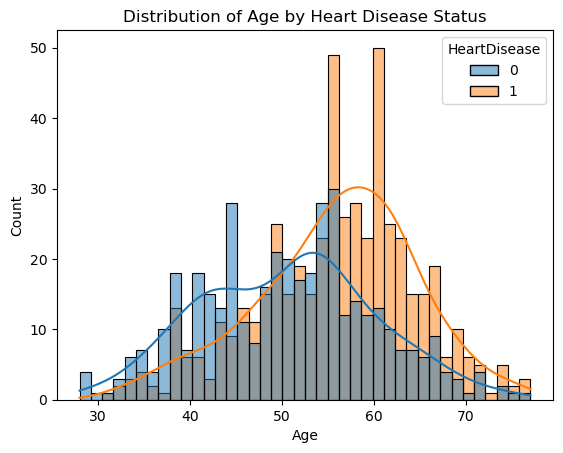

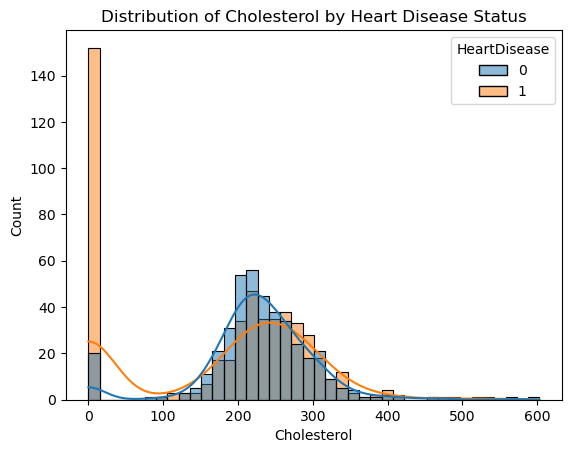

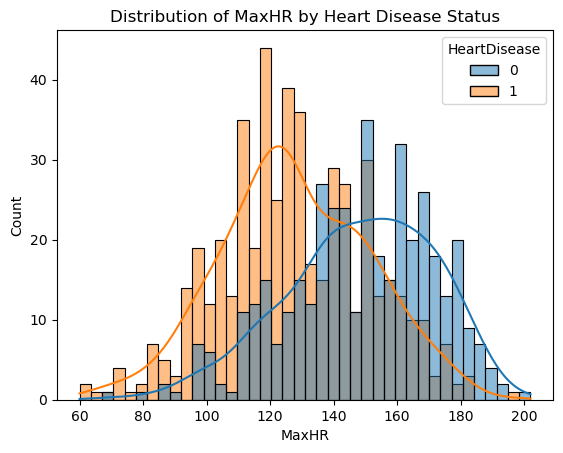

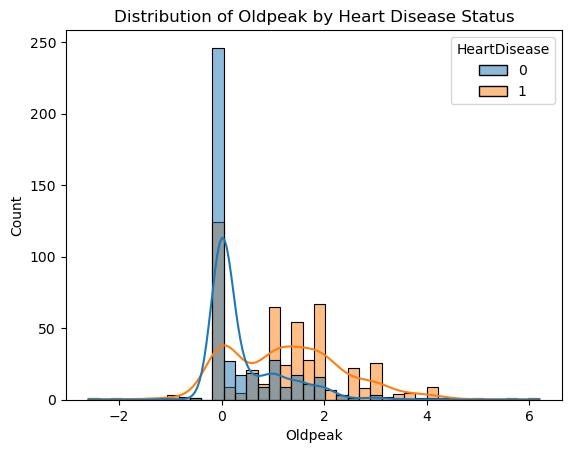

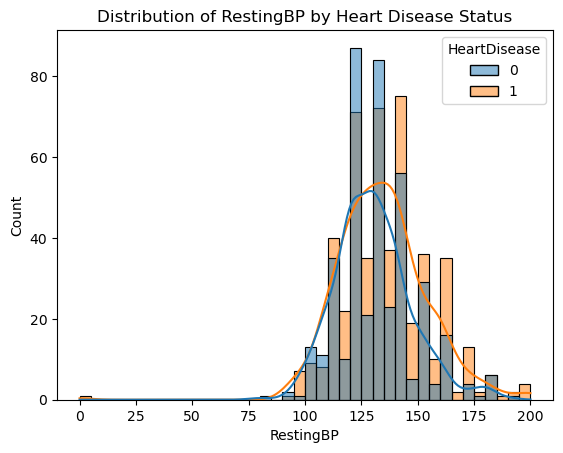

In [17]:
for var in num_vars:
    sns.histplot(data=df, x=var, bins=40, kde=True, hue='HeartDisease')
    plt.title(f'Distribution of {var} by Heart Disease Status')
    plt.show()

### Observations From Numerical Distributions
- The mean age of patients who have heart disease is higher than when they do not have heart disease.
- The mean maximum heart rate for patients who have heart disease is lower than when they do not.

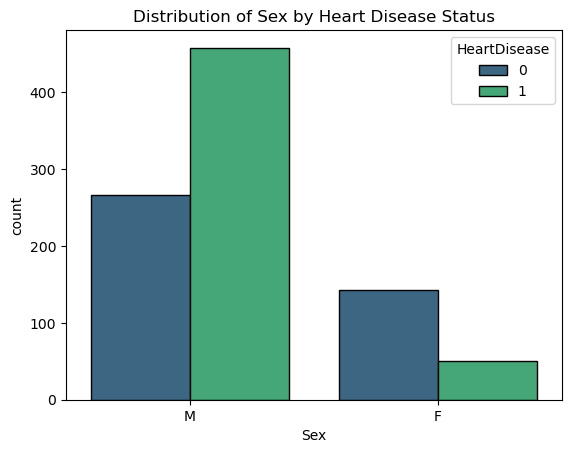

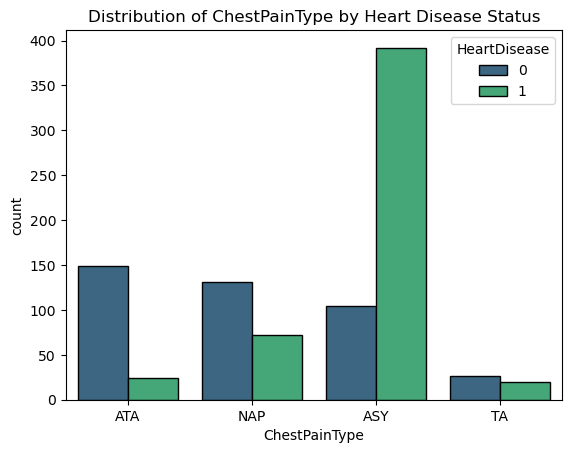

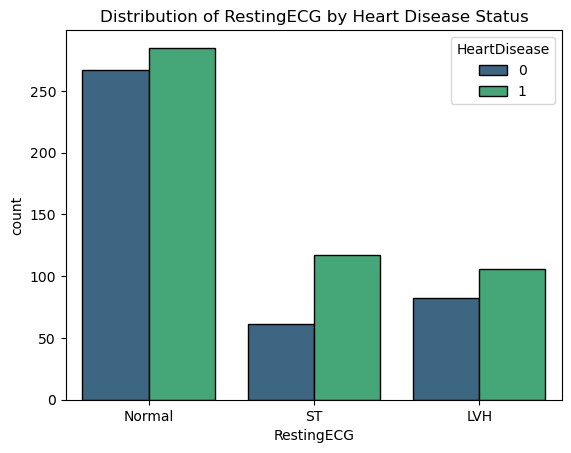

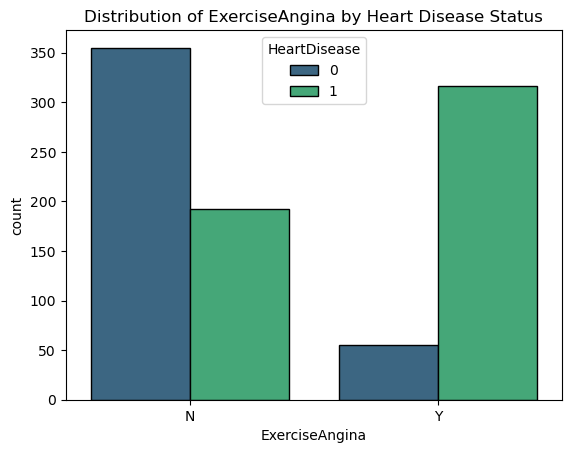

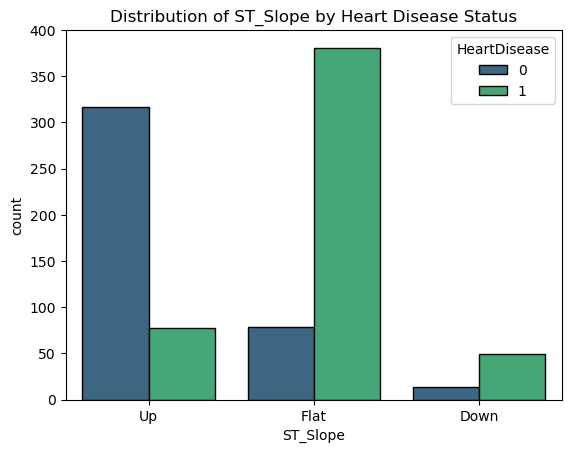

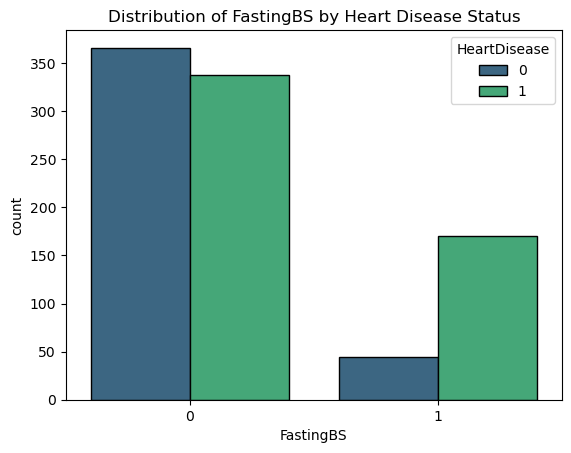

In [18]:
for var in cat_vars:
    sns.countplot(df, x=var, hue='HeartDisease', edgecolor='black', palette='viridis')
    plt.title(f'Distribution of {var} by Heart Disease Status')
    plt.show()

### Observations From Distributions
- There are many more patiets who are males that have heart disease present versus females who have heart disease.
- There are many more patients who have asymptomatic chest pain that have heart disease versus not. 
- Among the patients who have atypical angina there are many more who *Do Not* have heart disease than those that do
- There are more patients with Exercise Angina that have heart disease versus those that do not.
- ST Elevation
- ST Slope Flat and Down
- ST Slope up (negatively correlated)
- Fasting Blood Sugar (positively correlated)

## Odds Ratios

> The previous observations were only from visually inspecting the distributions of the numerical and categorical data.
> 
> Now, the odds ratios will be calculated to get a quantifiable measurement as to which variables cause patients to have a higher odds of having heart disease.

In [19]:
def get_odds_and_interval(exogeneous, endogeneous):
    y = endogeneous # Dependent Variable
    if exogeneous.name in cat_vars: # Print out the different variables for categorical variables to see which is the reference variable
        print('Variables:')
        for x in exogeneous.unique():
            print(x)
        X = pd.get_dummies(exogeneous, drop_first=True, dtype=int) # Independent variable
        X = sm.add_constant(X)
        result = sm.Logit(y, X).fit()
        print(result.summary())
        print(np.exp(result.params))
        print(np.exp(result.conf_int()))
        print()
    else:
        X = exogeneous
        X = sm.add_constant(X)
        result = sm.Logit(y, X).fit()
        print(result.summary())
        print(np.exp(result.params))
        print(np.exp(result.conf_int()))
        print()

In [20]:
for col in df.columns[:-1]:
    print(f'{col}: Odds Ratio and Confidence Interval')
    get_odds_and_interval(df[col], df['HeartDisease'])

Age: Odds Ratio and Confidence Interval
Optimization terminated successfully.
         Current function value: 0.646372
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:           HeartDisease   No. Observations:                  918
Model:                          Logit   Df Residuals:                      916
Method:                           MLE   Df Model:                            1
Date:                Sat, 15 Mar 2025   Pseudo R-squ.:                 0.05974
Time:                        12:00:42   Log-Likelihood:                -593.37
converged:                       True   LL-Null:                       -631.07
Covariance Type:            nonrobust   LLR p-value:                 3.850e-18
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.2131      0.420     -7.650      0.000      -4.036  

### Odds Ratios of Note From Binary Variables:
|Variable|Odds Ratio|Log Odds Ratio|
|--------|----------|--------|
|Chest Pain (Atypical Angina)|0.04|-3.15|
|ST Slope (Up)|0.07|-2.66|
|Exercise Angina (Y)|10.6|2.36|
|Sex (Male)|4.91|1.59|

*There were many other significant odds ratios. These were just a few that were especially severe*

#### Atypical Chest Pain (Angina) Information
Atypical chest pain is chest pain that doesn’t fit the description of typical or classic chest pain.

Typical or classic chest pain generally has all three of the following features:

- It feels like pressure or heaviness under your breastbone.
- It’s worse when you exert yourself.
- It lasts for at least two minutes and goes away when you rest or take nitroglycerin.

Atypical chest pain is a type of chest pain that only has some of the features of typical chest pain. It may also include chest pain that:

- Lasts for a few seconds, then quickly subsides.
- Worsens when your body is in certain positions.
- Feels like a sharp or stabbing pain.

Atypical chest pain is the top symptom of people who visit the emergency department or their primary healthcare provider. For 66% of them, their heart isn’t the cause of their pain.

> This information is from the Cleveland Clinic

#### Most Common Causes of ST Segment Elevation
- Acute myocardial infarction
- Coronary vasospasm (Printzmetal’s angina)
- Pericarditis
- Benign early repolarization
- Left bundle branch block
- Left ventricular hypertrophy
- Ventricular aneurysm
- Brugada syndrome
- Ventricular paced rhythm
- Raised intracranial pressure
- Takotsubo Cardiomyopathy

## More Exploration Among Variables With Most Significant Log Odds Ratio

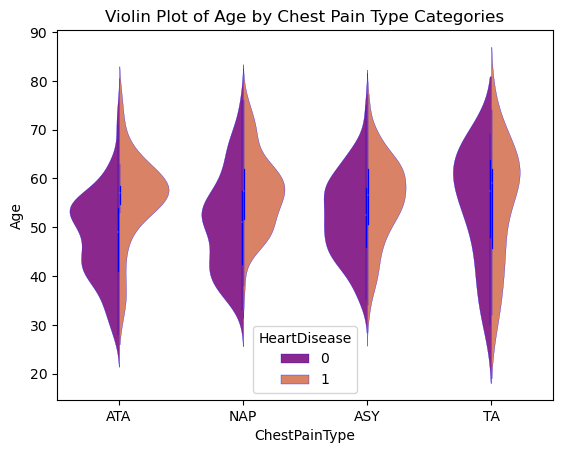

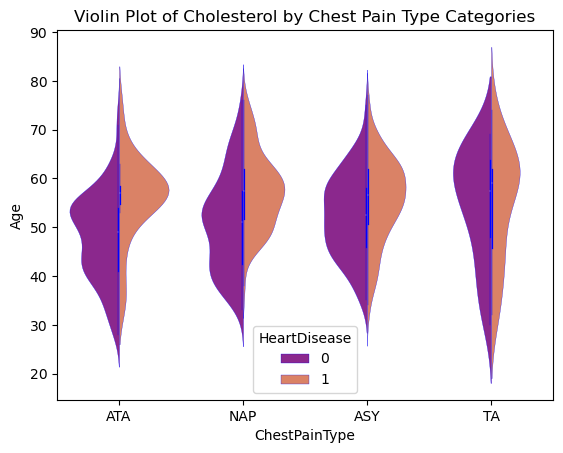

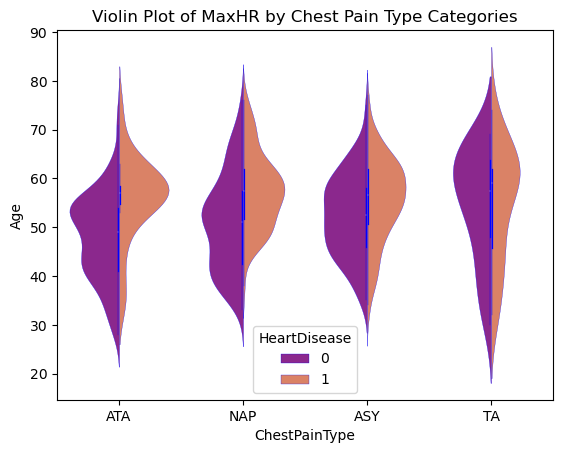

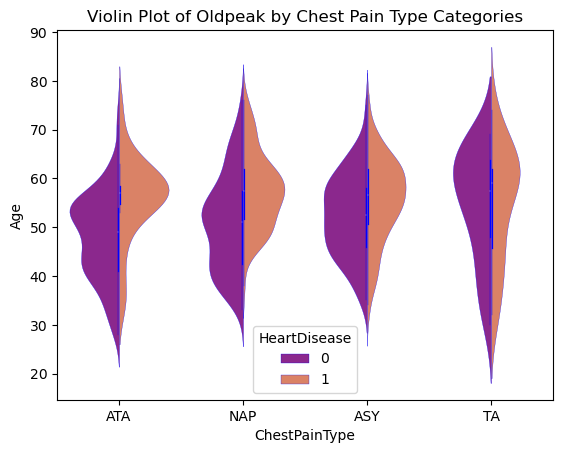

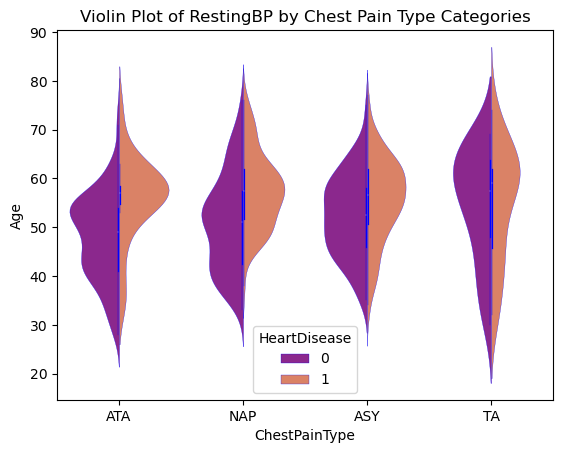

In [21]:
for var in num_vars:
    sns.violinplot(data=df, x='ChestPainType', y='Age', hue='HeartDisease', palette='plasma', edgecolor='b', linewidth=.2, split=True)
    plt.title(f'Violin Plot of {var} by Chest Pain Type Categories')
    plt.show()

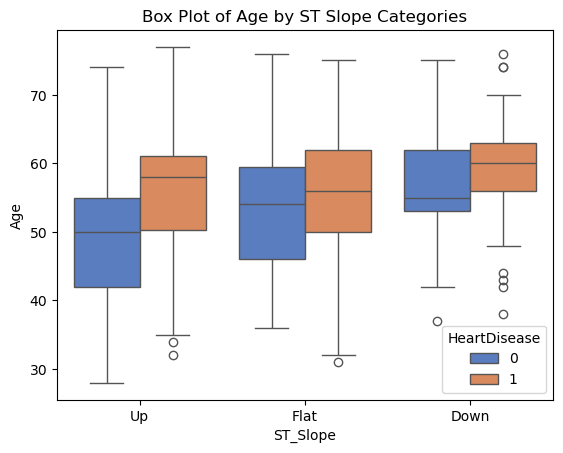

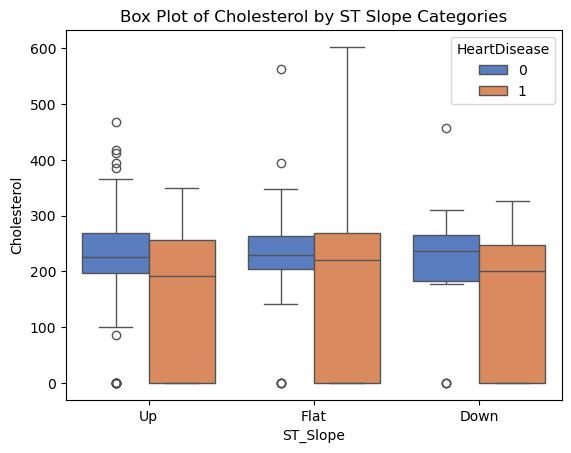

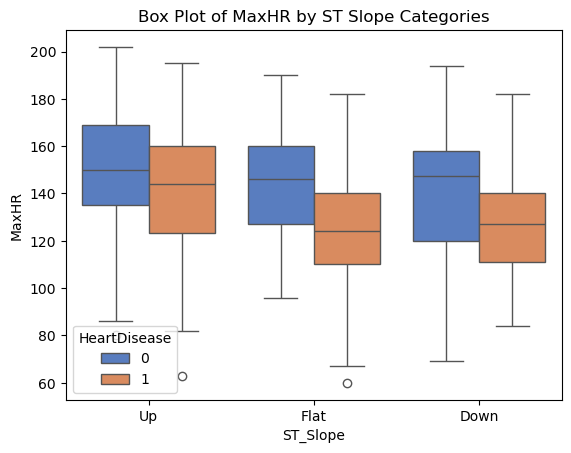

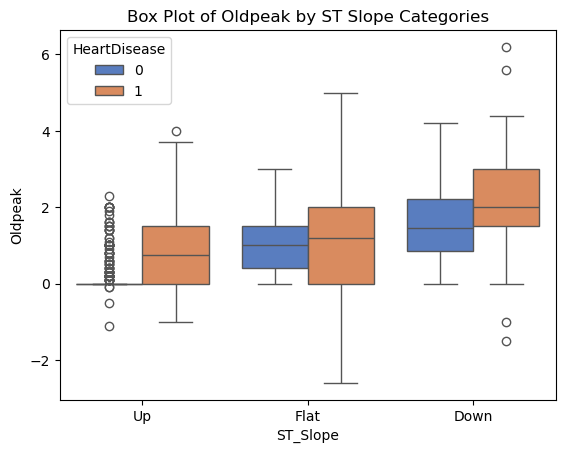

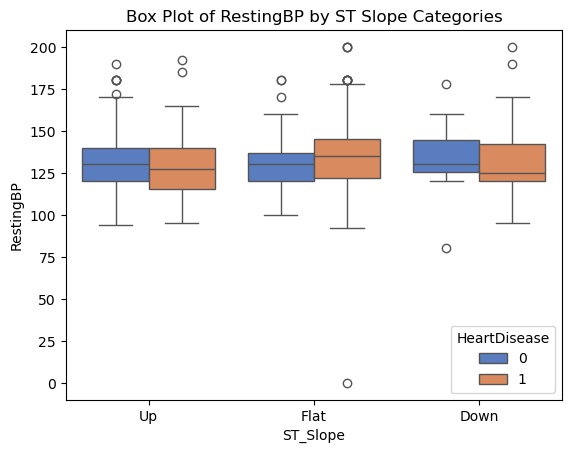

In [22]:
for var in num_vars:
    sns.boxplot(data=df, x='ST_Slope', y=var, hue='HeartDisease', palette='muted')
    plt.title(f'Box Plot of {var} by ST Slope Categories')
    plt.show()


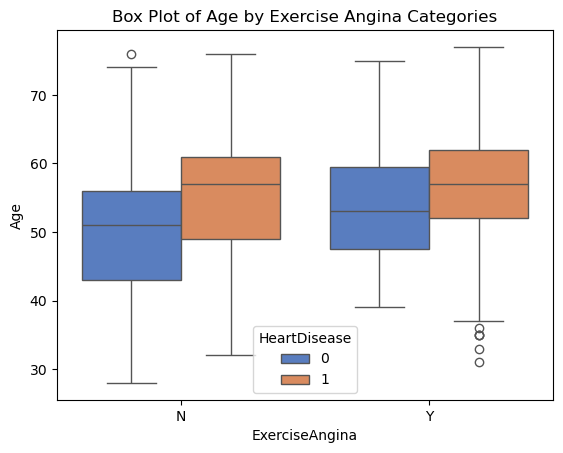

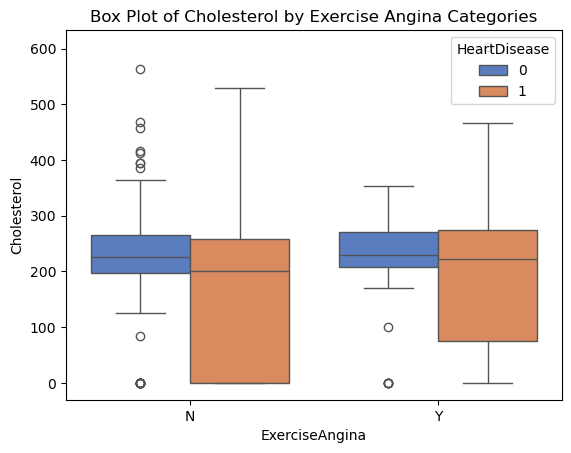

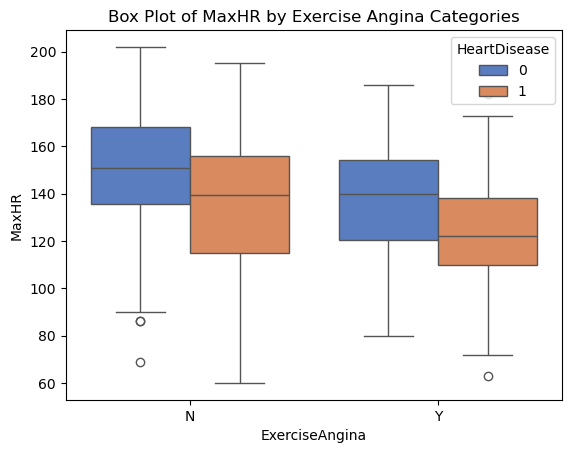

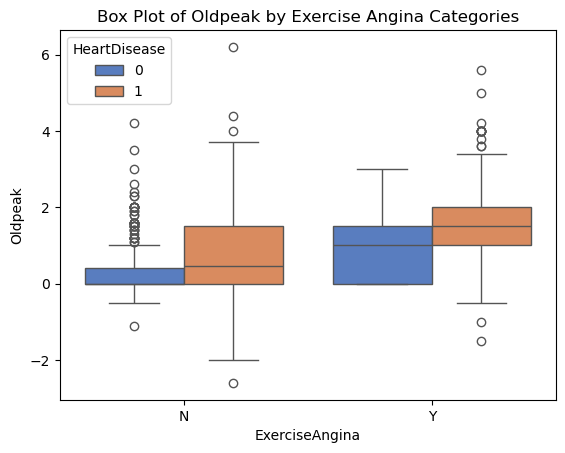

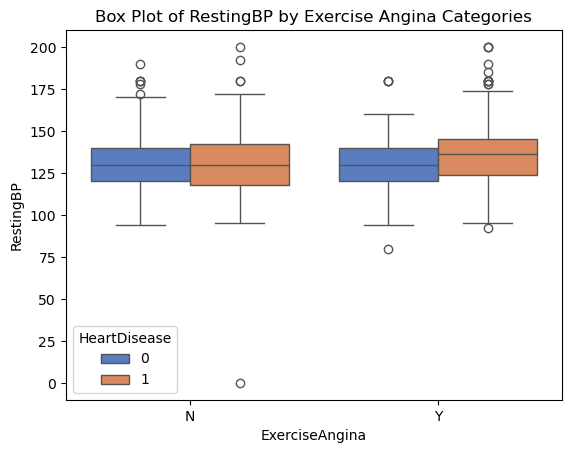

In [23]:
for var in num_vars:
    sns.boxplot(data=df, x='ExerciseAngina', y=var, hue='HeartDisease', palette='muted')
    plt.title(f'Box Plot of {var} by Exercise Angina Categories')
    plt.show()

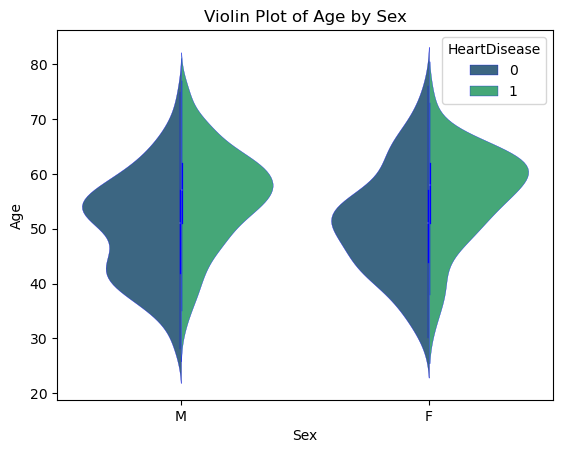

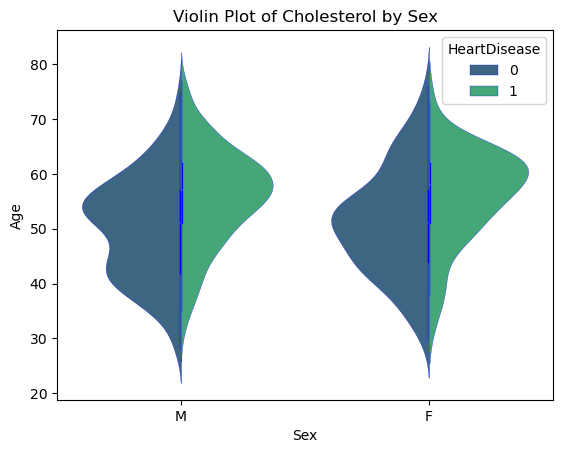

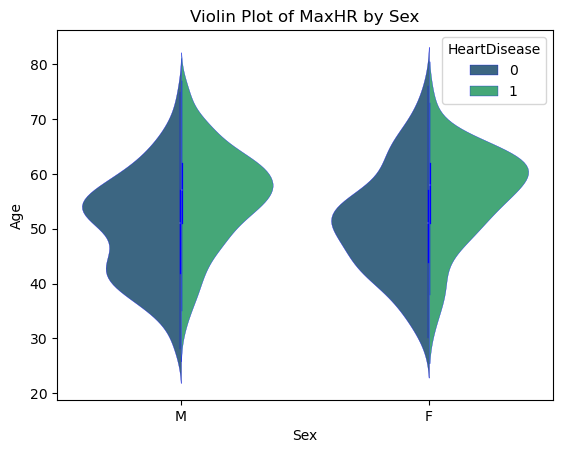

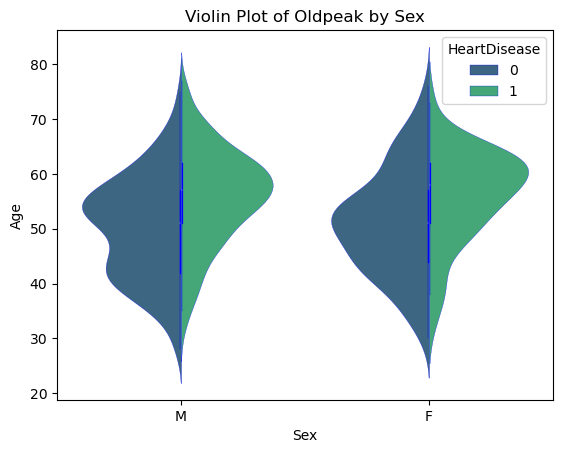

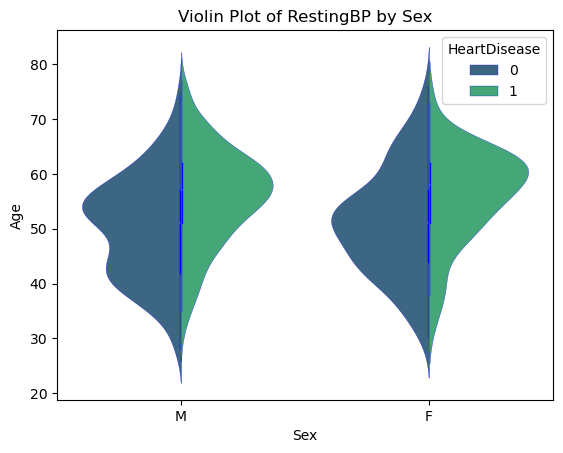

In [24]:
for var in num_vars:
    sns.violinplot(data=df, x='Sex', y='Age', hue='HeartDisease', palette='viridis', edgecolor='b', linewidth=.2, split=True)
    plt.title(f'Violin Plot of {var} by Sex')
    plt.show()

# Pre Model Building

In [25]:
# Features
X = df.drop('HeartDisease', axis=1)
# Target Variable
y = df['HeartDisease']

# Train test split setting stratify = y ensures the target class distribution is maintained across train and test sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Resetting the indexes to avoid future merging issues
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

In [26]:
continuous_vars = [
    'Age',
    'Cholesterol',
    'MaxHR',
    'Oldpeak',
    'RestingBP'
]

binary_vars = [
    'Sex_M',
    'ExerciseAngina_Y',
    'FastingBS' # Already (0/1)
]

nominal_vars = [
    'ChestPainType',
    'RestingECG',
    'ST_Slope'
]

In [27]:
# Converting binary variables to 0/1 values
X_train['Sex_M'] = X_train['Sex'].map({'F': 0, 'M': 1})
X_train['ExerciseAngina_Y'] = X_train['ExerciseAngina'].map({'N': 0, 'Y': 1})
X_train.drop(['Sex', 'ExerciseAngina'], axis=1, inplace=True)

X_test['Sex_M'] = X_test['Sex'].map({'F': 0, 'M': 1})
X_test['ExerciseAngina_Y'] = X_test['ExerciseAngina'].map({'N': 0, 'Y': 1})
X_test.drop(['Sex', 'ExerciseAngina'], axis=1, inplace=True)

## Imputing Missing Values

<Axes: >

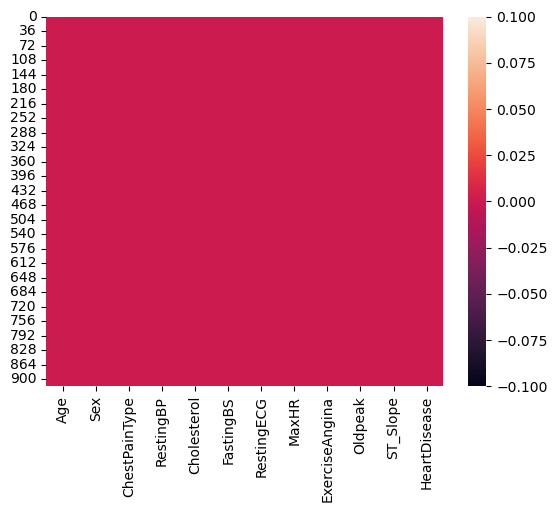

In [28]:
sns.heatmap(df.isnull())

No missing values to impute

## Standardization and One-Hot-Encoding

In [29]:
std_scaler = StandardScaler()
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')
transformer = ColumnTransformer(transformers=[
    ('num', std_scaler, continuous_vars), # Standardizing continuous variables
    ('cat', ohe, nominal_vars), # One-hot-encoding nominal categorical variables
    ('bin', 'passthrough', binary_vars) # Binary variables need no change so let them passthrough
], verbose_feature_names_out=False)

In [30]:
X_train_final = pd.DataFrame(transformer.fit_transform(X_train), columns=transformer.get_feature_names_out())
X_test_final = pd.DataFrame(transformer.transform(X_test), columns=transformer.get_feature_names_out())

In [31]:
X_train_final

,Age,Cholesterol,MaxHR,Oldpeak,RestingBP,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up,Sex_M,ExerciseAngina_Y,FastingBS
0,0.970012,0.127137,-0.324520,0.317046,0.339016,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,0.122028,0.099443,1.689837,-0.440356,-1.266031,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
2,0.546020,1.244113,-0.247045,0.601071,-0.159102,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0
3,-0.725956,-1.876035,-0.479470,-0.819056,1.501291,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,-0.407962,-1.876035,0.101594,-0.156330,0.671094,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
729,-0.301964,-0.399042,0.527708,1.074447,0.117630,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
730,-0.831954,0.247142,0.527708,-0.819056,-0.712567,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
731,0.546020,0.274836,-0.750634,0.411721,-0.601874,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
732,0.758016,0.819477,-0.828109,-0.819056,-0.435834,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0


In [32]:
X_test_final

,Age,Cholesterol,MaxHR,Oldpeak,RestingBP,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_Normal,RestingECG_ST,ST_Slope_Flat,ST_Slope_Up,Sex_M,ExerciseAngina_Y,FastingBS
0,-0.831954,-1.876035,-0.905584,0.601071,-0.989299,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
1,0.440022,0.191755,1.418673,2.210549,-0.048409,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0.652018,0.505616,0.179069,1.831848,-0.435834,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
3,-0.513960,-0.140568,0.101594,1.074447,-0.712567,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,-1.573940,0.154830,0.605183,-0.819056,0.283669,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,-0.937952,0.191755,-0.556946,-0.819056,0.394362,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
180,0.228026,0.422535,0.295282,0.317046,-0.435834,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0
181,-0.513960,-1.876035,0.334020,2.021198,-0.159102,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
182,0.546020,0.330223,0.217807,0.317046,-1.266031,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0


In [33]:
X_train_final.shape

(734, 15)

In [34]:
X_test_final.shape

(184, 15)

# Model Building

## Random Forest Classifier

In [35]:
# Test out 1-300 estimators for our model to see what hyperparamter to choose for our Random Forest Model

scores =[]
for k in range(1,300):
    rfc = RandomForestClassifier(n_estimators=k, random_state=42)
    rfc.fit(X_train_final, y_train)
    rfc_pred = rfc.predict(X_test_final)
    scores.append(accuracy_score(y_test, rfc_pred))

Text(0, 0.5, 'Accuracy')

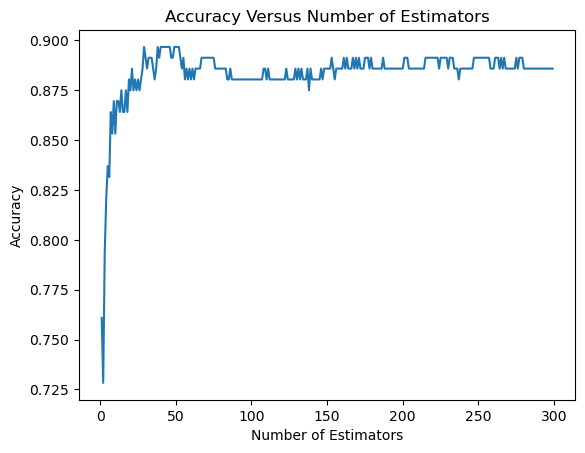

In [36]:
plt.plot(range(1,300), scores)
plt.title("Accuracy Versus Number of Estimators")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")

It tapers off pretty quickly, but we will choose to use 125 N_estimators

## Make Predictions

In [37]:
rfc = RandomForestClassifier(n_estimators=125)
rfc.fit(X_train_final, y_train)
rfc_pred = rfc.predict(X_test_final)
rfc_scores = rfc.predict_proba(X_test_final)[:, 1] #Probabilities of each sample belonging to the heart_disease=y class

## Formatted Confusion Matrix and Classification Report

              precision    recall  f1-score   support

           0       0.88      0.83      0.86        82
           1       0.87      0.91      0.89       102

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.87       184
weighted avg       0.88      0.88      0.87       184



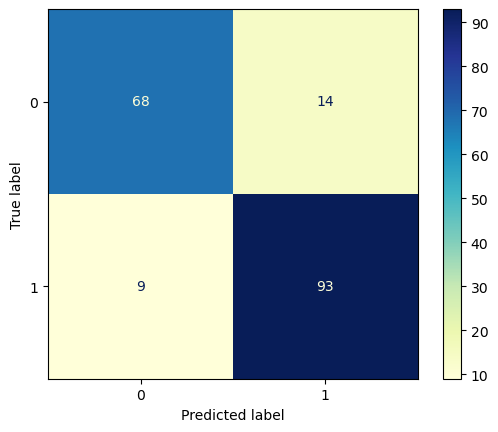

In [38]:
print(classification_report(y_test, rfc_pred))
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, rfc_pred))
cm_display.plot(cmap='YlGnBu',)

True Negative (Top-Left Quadrant)

False Positive (Top-Right Quadrant)

False Negative (Bottom-Left Quadrant)

True Positive (Bottom-Right Quadrant)

## Receiver Operating Characteristic Area Under the Curve (AUC-ROC)

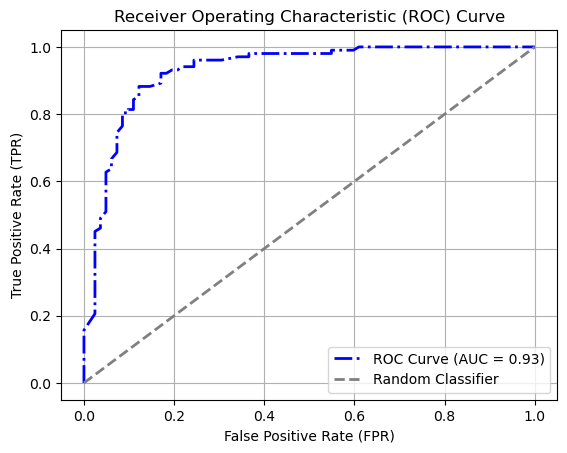

In [39]:
fpr, tpr, thresholds = roc_curve(y_test, rfc_scores)
plt.plot(fpr, tpr, color='blue', linestyle='-.', lw=2, label=f'ROC Curve (AUC = {roc_auc_score(y_test, rfc_scores):.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label="Random Classifier")

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)



## Precision Recall Curve

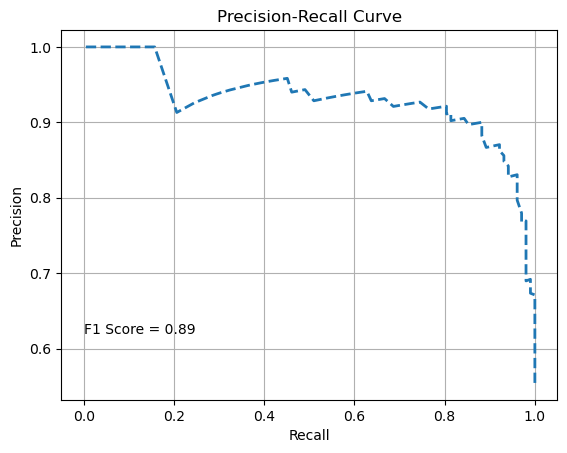

In [40]:
rfc_f1 = f1_score(y_test, rfc_pred)
precision,recall,_ = precision_recall_curve(y_test, rfc_scores)
plt.plot(recall, precision, lw=2, linestyle='--')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.text(x=0, y=0.62, s=f"F1 Score = {rfc_f1:.2f}")
plt.grid(True)

## Precision Recall Versus Threshold Curve

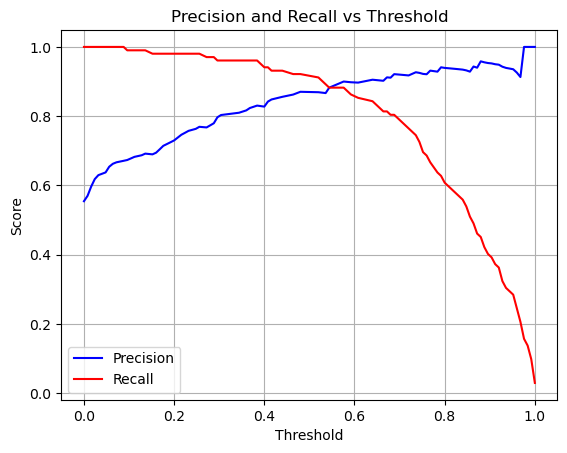

In [41]:
precision, recall, thresholds = precision_recall_curve(y_test, rfc_scores)

# Plot precision and recall vs threshold
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="red")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid(True)

In [42]:
# Manually Setting the Threshold of the predictions to increase recall at the expense of precision
threshold = 0.4
manual_predict = (rfc_scores>=threshold).astype(int)

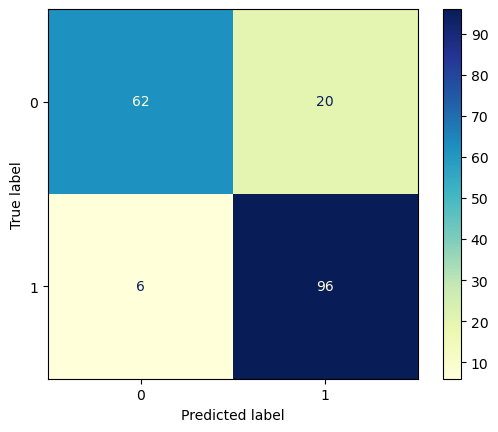

In [43]:
cm_display2 = ConfusionMatrixDisplay(confusion_matrix(y_test, manual_predict))
cm_display2.plot(cmap='YlGnBu')

With the manual predictions there are less false negatives

## Feature Importance

In [44]:
features = pd.DataFrame({'Variables': X_train_final.columns, 'Importance': rfc.feature_importances_})
top_10 = features.sort_values(by='Importance', ascending=False).head(10)

Text(0.5, 1.0, 'Feature Importance')

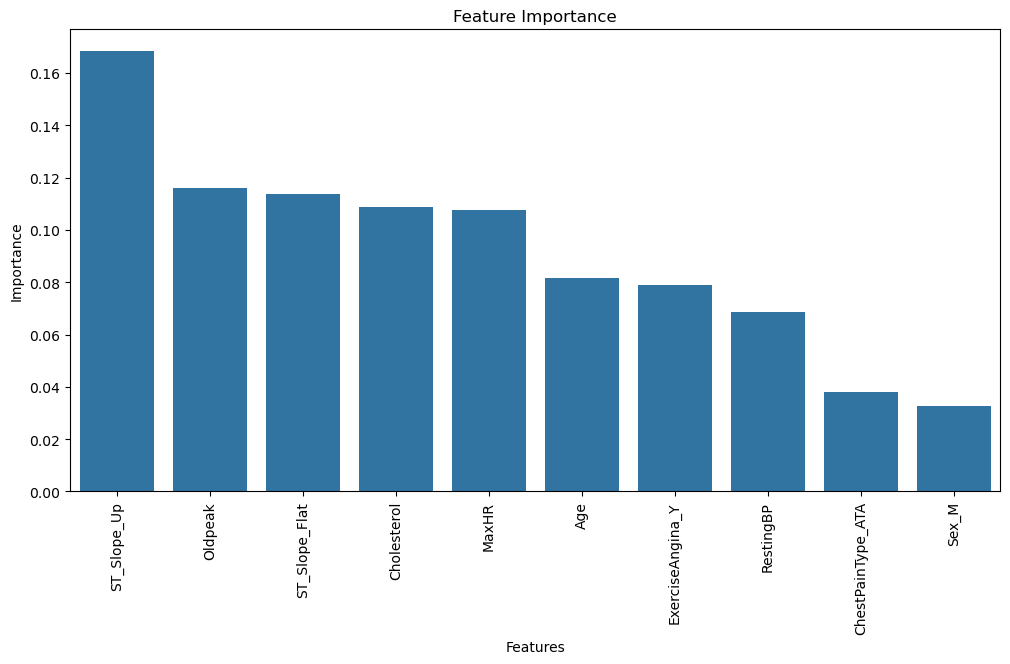

In [45]:
plt.figure(figsize=(12,6))
sns.barplot(x=top_10['Variables'], y=top_10['Importance'])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")

ST_Slope_Up has the highest feature importance, meaning it does the best job of reducing Gini impurity and splitting the data compared to the other features.

### Pipeline for model building

In [46]:
# Pipeline
def model_build_eval(model, name):
    # Training the Model and predicting
    md = model
    md.fit(X_train_final, y_train)
    pred = md.predict(X_test_final)
    y_score = md.predict_proba(X_test_final)[:,1] # Probabilities of each data being classified as the positive class
    
    print("Classification Report")
    print(classification_report(y_test, pred))
    
    cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, pred))
    cm_display.plot(cmap='YlGnBu')
    plt.title(f"{name} Confusion Matrix")
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC={roc_auc_score(y_test, y_score):.2f})')
    plt.plot([0,1], [0,1], color='gray', linestyle='--', lw=2, label="Random Classifier")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} Reciever Operator Characteristic (ROC) Curve")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    # Precision and Recall Curve
    f1 = f1_score(y_test, pred)
    precision,recall,_ = precision_recall_curve(y_test, y_score)
    plt.plot(recall, precision, lw=2, linestyle='--')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{name} Precision-Recall Curve")
    plt.text(x=0, y=0.62, s=f"F1 Score = {f1:.2f}")
    plt.grid(True)
    plt.show()
    
    # Plot precision and recall vs threshold
    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
    plt.plot(thresholds, recall[:-1], label="Recall", color="red")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"{name} Precision and Recall vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return md

## Logistic Regression 
> **Without removing collinear features**

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.83      0.87        82
           1       0.87      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184



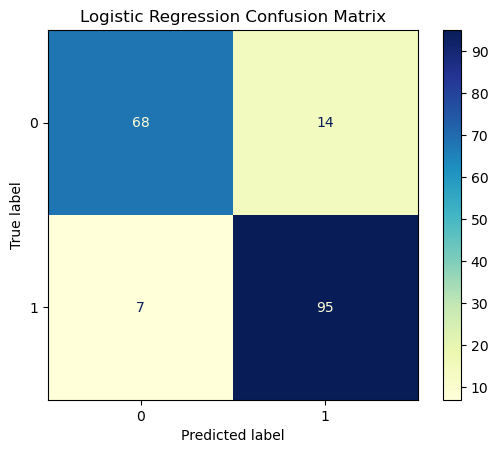

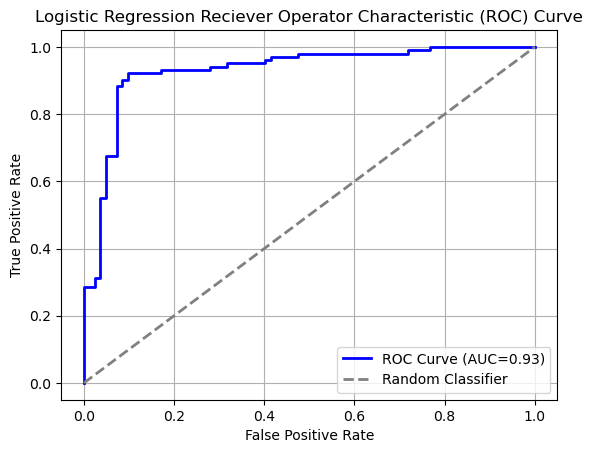

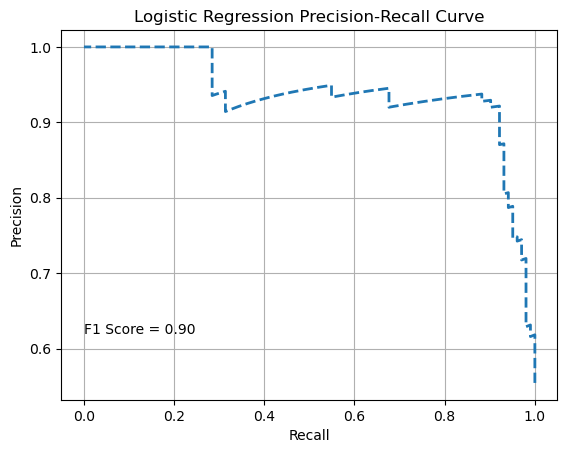

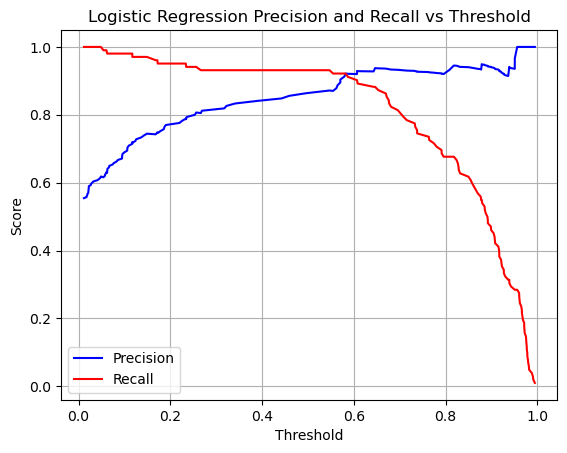

In [48]:
lr = model_build_eval(LogisticRegression(random_state=42), "Logistic Regression")

In [ ]:
lr.coef_[0]

array([ 0.0350996 , -0.48910488, -0.20070703,  0.28937996,  0.0351328 ,
       -1.46249518, -1.67892172, -1.14021767, -0.34272449, -0.31563982,
        0.9900453 , -1.38587947,  1.10379919,  0.90184125,  0.93274463])

In [ ]:
lr_features = pd.DataFrame({
    'Features': X_train_final.columns,
    'Importance': lr.coef_[0]
}).sort_values(by='Importance', ascending=False).head(10)

In [ ]:
lr_features

,Features,Importance
12,Sex_M,1.103799
10,ST_Slope_Flat,0.990045
14,FastingBS,0.932745
13,ExerciseAngina_Y,0.901841
3,Oldpeak,0.289380
4,RestingBP,0.035133
0,Age,0.035100
2,MaxHR,-0.200707
9,RestingECG_ST,-0.315640
8,RestingECG_Normal,-0.342724


Text(0.5, 1.0, 'Feature Importance')

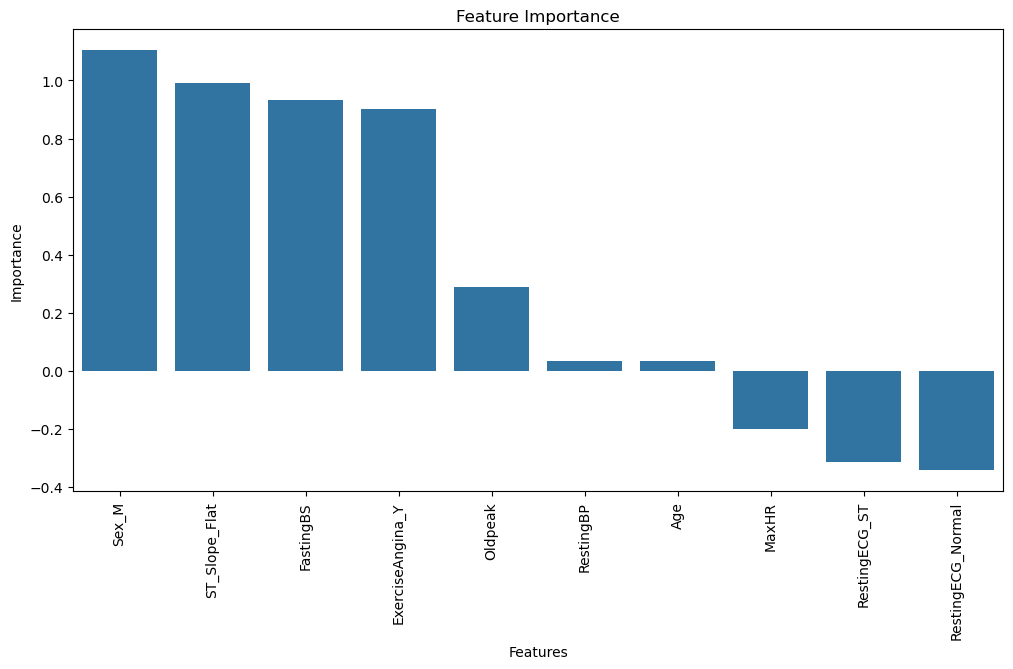

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x=lr_features['Features'], y=lr_features['Importance'])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")

## Logistic Regression
> **With removing collinear features**

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.82      0.86        82
           1       0.86      0.93      0.90       102

    accuracy                           0.88       184
   macro avg       0.88      0.87      0.88       184
weighted avg       0.88      0.88      0.88       184



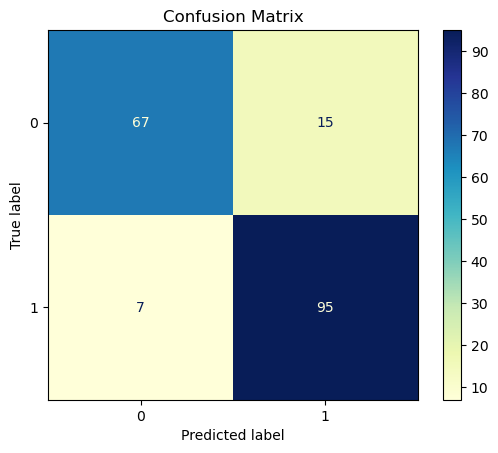

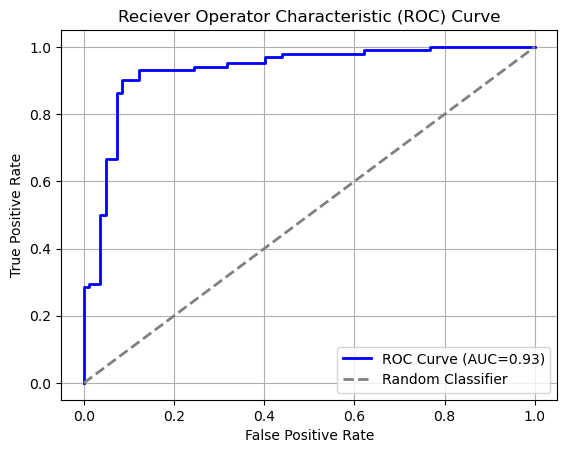

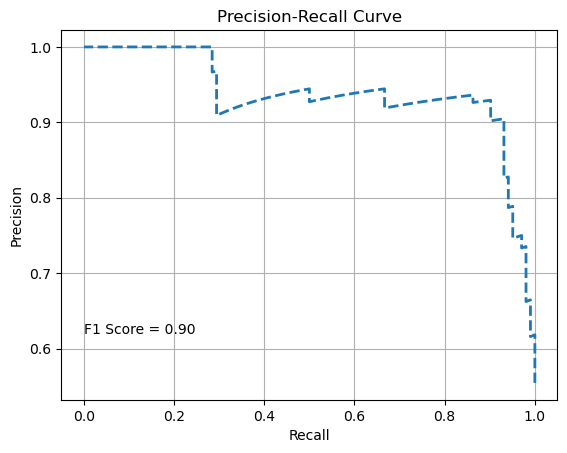

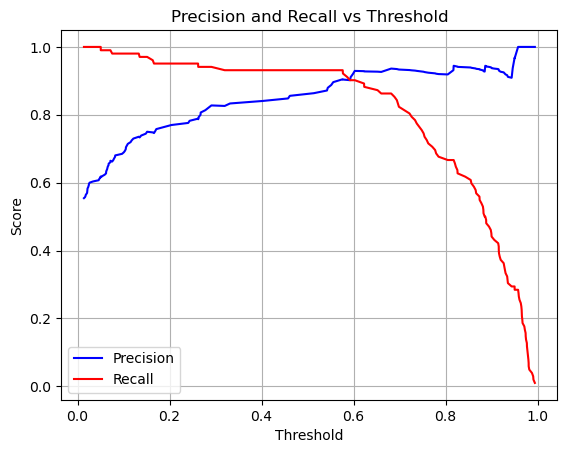

In [ ]:
lr_collinear = LogisticRegression()
lr_collinear.fit(X_train_final.drop(['RestingBP', 'MaxHR'], axis=1), y_train)
pred = lr_collinear.predict(X_test_final.drop(['RestingBP', 'MaxHR'], axis=1))
y_score = lr_collinear.predict_proba(X_test_final.drop(['RestingBP', 'MaxHR'], axis=1))[:,1] # Probabilities of each data being classified as the positive class

print("Classification Report")
print(classification_report(y_test, pred))

cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, pred))
cm_display.plot(cmap='YlGnBu')
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC={roc_auc_score(y_test, y_score):.2f})')
plt.plot([0,1], [0,1], color='gray', linestyle='--', lw=2, label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Reciever Operator Characteristic (ROC) Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Precision and Recall Curve
f1 = f1_score(y_test, pred)
precision,recall,_ = precision_recall_curve(y_test, y_score)
plt.plot(recall, precision, lw=2, linestyle='--')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.text(x=0, y=0.62, s=f"F1 Score = {f1:.2f}")
plt.grid(True)
plt.show()

# Plot precision and recall vs threshold
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="red")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision and Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
lr_collinear_features = pd.DataFrame({
    'Features': X_train_final.drop(['RestingBP', 'MaxHR'], axis=1).columns,
    'Importance': lr_collinear.coef_[0]
}).sort_values(by='Importance', ascending=False).head(10)
lr_collinear_features

,Features,Importance
10,Sex_M,1.130351
8,ST_Slope_Flat,0.992867
11,ExerciseAngina_Y,0.966481
12,FastingBS,0.918489
2,Oldpeak,0.268488
0,Age,0.107263
7,RestingECG_ST,-0.206494
6,RestingECG_Normal,-0.278656
1,Cholesterol,-0.516487
5,ChestPainType_TA,-1.183238


Text(0.5, 1.0, 'Feature Importance')

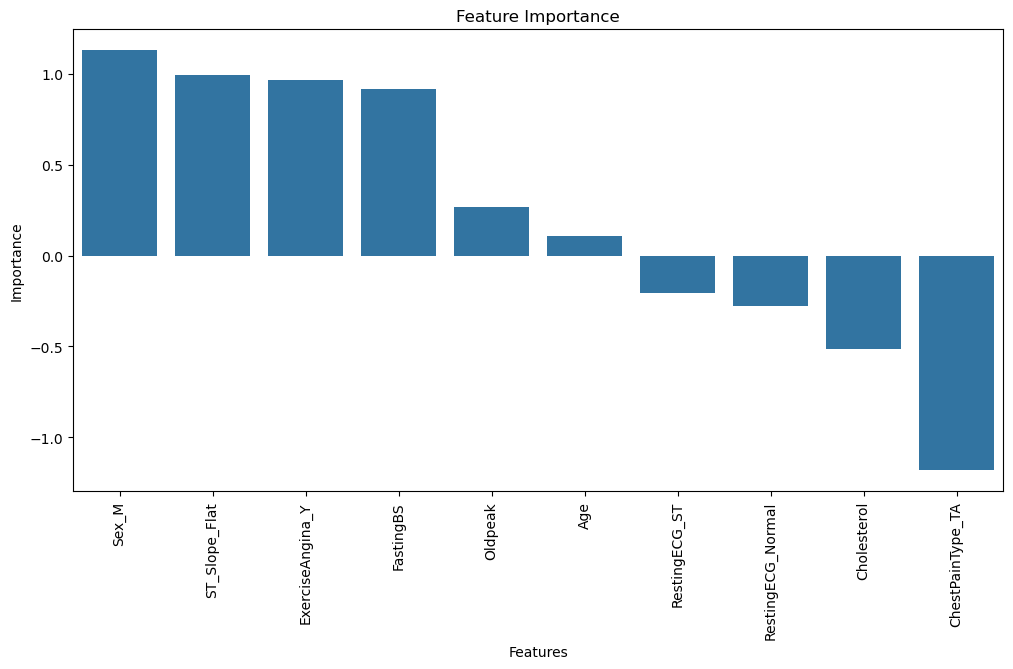

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x=lr_collinear_features['Features'], y=lr_collinear_features['Importance'])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")

> Taking out potentially collinear features, had little effect on the logistic regression model performance. The overall accuracy actually went slightly down without the additional features.

## K Nearest Neighbors

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_final, y_train)
knn_pred = knn.predict(X_test_final)

              precision    recall  f1-score   support

           0       0.85      0.80      0.82        82
           1       0.85      0.88      0.87       102

    accuracy                           0.85       184
   macro avg       0.85      0.84      0.85       184
weighted avg       0.85      0.85      0.85       184



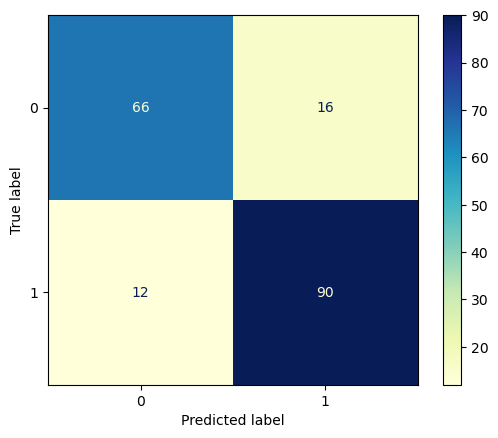

In [ ]:
knn_cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, knn_pred))
knn_cm_display.plot(cmap='YlGnBu')
print(classification_report(y_test, knn_pred))

In [ ]:
# Using the elbow method to decide on the best k-value
error_rate = []
for k in range(1, 40):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_final, y_train)
    pred = knn.predict(X_test_final)
    error_rate.append(np.mean(pred!=y_test))

Text(0.5, 1.0, 'K Value versus Error Rate')

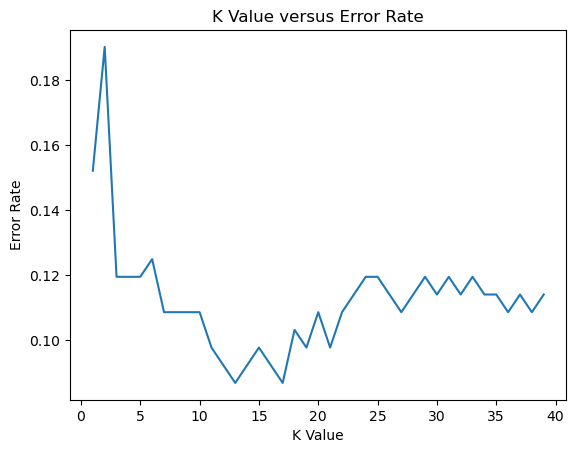

In [ ]:
plt.plot(range(1, 40), error_rate)
plt.xlabel("K Value")
plt.ylabel("Error Rate")
plt.title("K Value versus Error Rate")

Based on the Error Rate Versus K-Value Graph, I will choose a K value of 21

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        82
           1       0.90      0.92      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



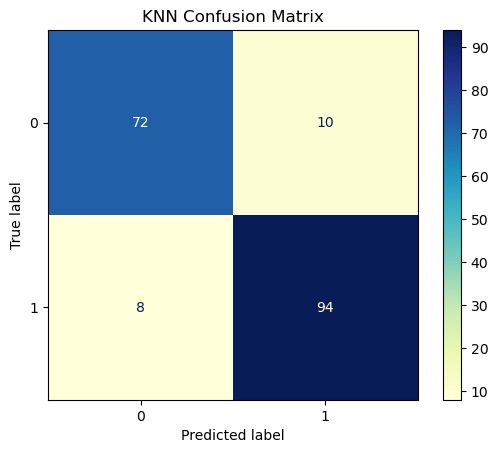

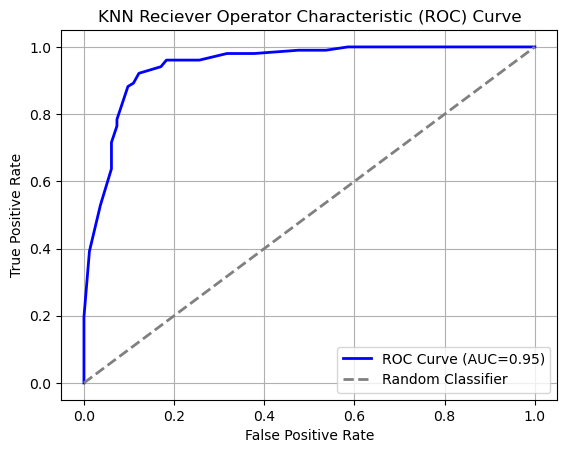

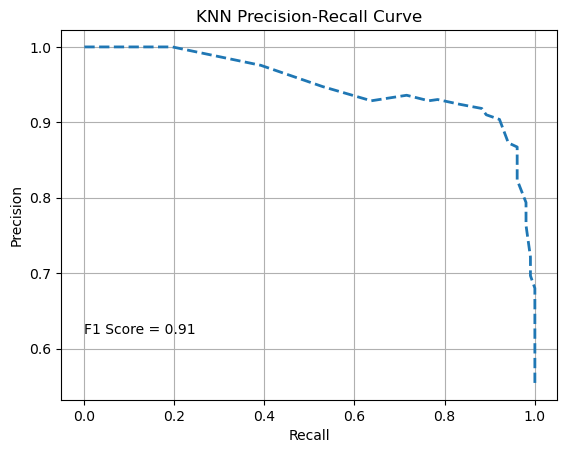

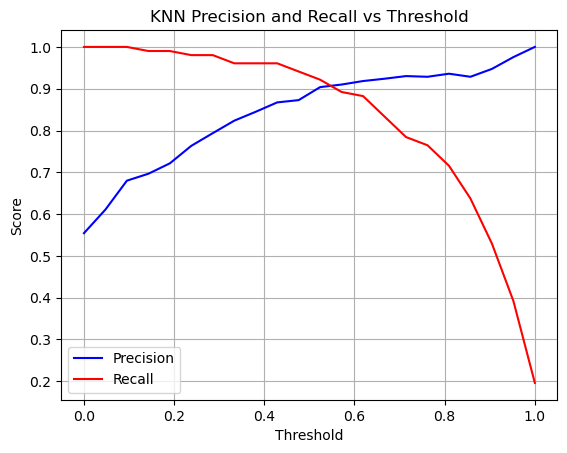

In [49]:
knn = model_build_eval(KNeighborsClassifier(n_neighbors=21), "KNN")

In [ ]:
knn_y_score = knn.predict_proba(X_test_final)[:, 1]

In [ ]:
# Manually Selecting a Threshold for a higher recall rate
threshold=0.4
knn_manual_predict = (knn_y_score >= threshold).astype(int)

              precision    recall  f1-score   support

           0       0.94      0.82      0.88        82
           1       0.87      0.96      0.91       102

    accuracy                           0.90       184
   macro avg       0.91      0.89      0.89       184
weighted avg       0.90      0.90      0.90       184



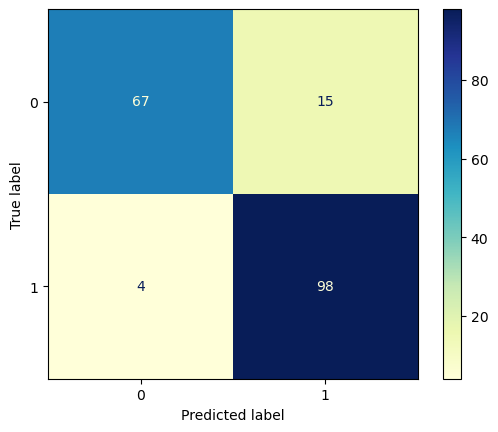

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix(y_test, knn_manual_predict))
cm_display.plot(cmap='YlGnBu')
print(classification_report(y_test, knn_manual_predict))

With a threshold of 0.4, Sensitivty in predicting positve cases increases from 0.92 to 0.96 whereas precision decreases from 0.9 to 0.87

KNN Feature Importance Technique (from sklearn): Permutation feature importance is a model inspection technique that measures the contribution of each feature to a fitted model’s statistical performance on a given tabular dataset. This technique is particularly useful for non-linear or opaque estimators, and involves randomly shuffling the values of a single feature and observing the resulting degradation of the model’s score. By breaking the relationship between the feature and the target, we determine how much the model relies on such particular feature.

In [ ]:
perm_importance = permutation_importance(knn, X_test_final, y_test, n_repeats=30, random_state=42, scoring='accuracy')

In [ ]:
knn_features = pd.DataFrame({
    'Features': X_train_final.columns,
    'Importance': perm_importance['importances_mean']
    }).sort_values(by='Importance', ascending=False).head(10)

Text(0.5, 1.0, 'KNN Feature Importance')

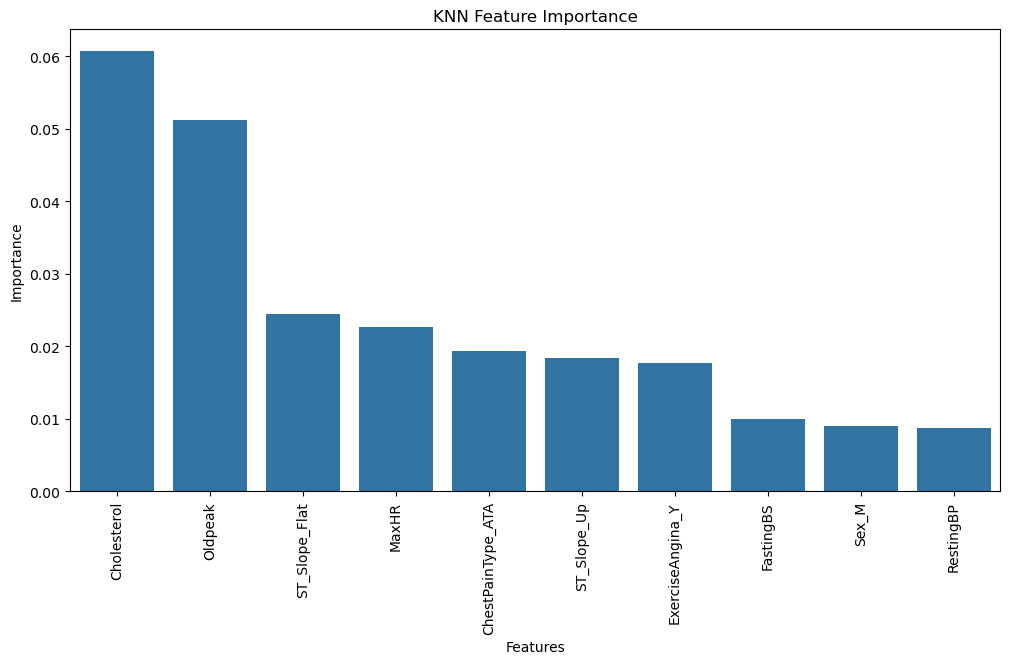

In [ ]:
plt.figure(figsize=(12,6))
sns.barplot(x=knn_features['Features'], y=knn_features['Importance'])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("KNN Feature Importance")

## XG Boost

In [52]:
# Using Bayes Search to find a Bayesian Optimization for hyperparameter tuning
# Most of these values came from Lianna and Justin YouTube Video on How to Train XGBoost Models in Python


xgb = XGBClassifier(random_state=42)

search_space = {
    'max_depth': Integer(2,8),
    'learning_rate': Real(0.001, 1.0, prior='log-uniform'),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0),
    'colsample_bynode': Real(0.5, 1.0),
    'reg_alpha': Real(0.0, 10.0),
    'reg_lambda': Real(0.0, 10.0), 
    'gamma': Real(0.0, 10.0),
    'min_child_weight': Integer(5,20),
    'n_estimators': Integer(50, 300)
}

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        82
           1       0.90      0.90      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.89      0.89       184
weighted avg       0.89      0.89      0.89       184



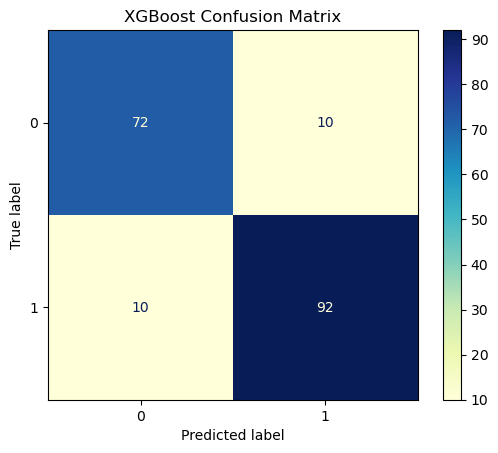

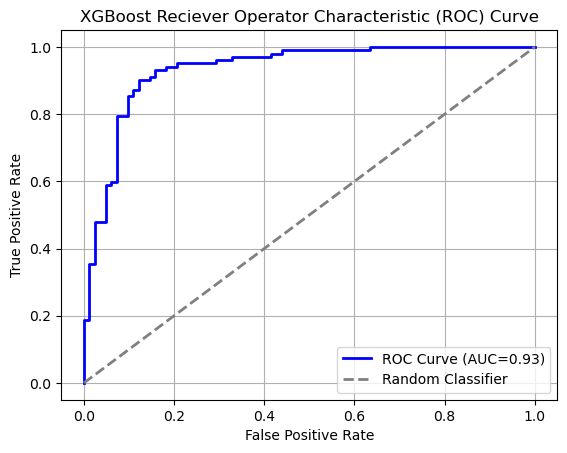

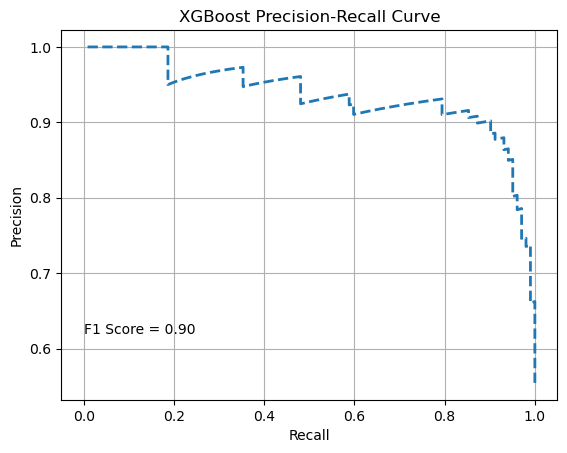

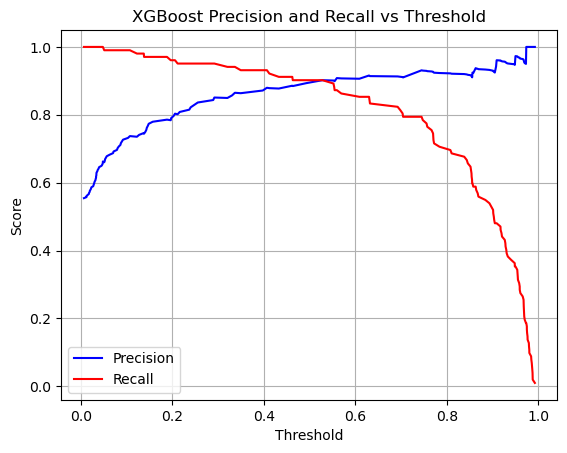

In [53]:
opt = model_build_eval(BayesSearchCV(xgb, search_space, cv=5, n_iter=40, scoring='roc_auc', random_state=42, verbose=0), "XGBoost")

In [54]:
print(opt.best_estimator_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.5,
              colsample_bytree=0.5, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05460598294456224,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


In [55]:
best_xgb = opt.best_estimator_

In [56]:
xgb_features = pd.DataFrame({
    'Features': X_train_final.columns,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

In [57]:
xgb_features

,Features,Importance
11,ST_Slope_Up,0.249184
10,ST_Slope_Flat,0.169405
5,ChestPainType_ATA,0.092696
13,ExerciseAngina_Y,0.083159
6,ChestPainType_NAP,0.074723
12,Sex_M,0.073990
3,Oldpeak,0.062557
1,Cholesterol,0.045317
2,MaxHR,0.044037
14,FastingBS,0.038029


Text(0.5, 1.0, 'XGBoost Feature Importance')

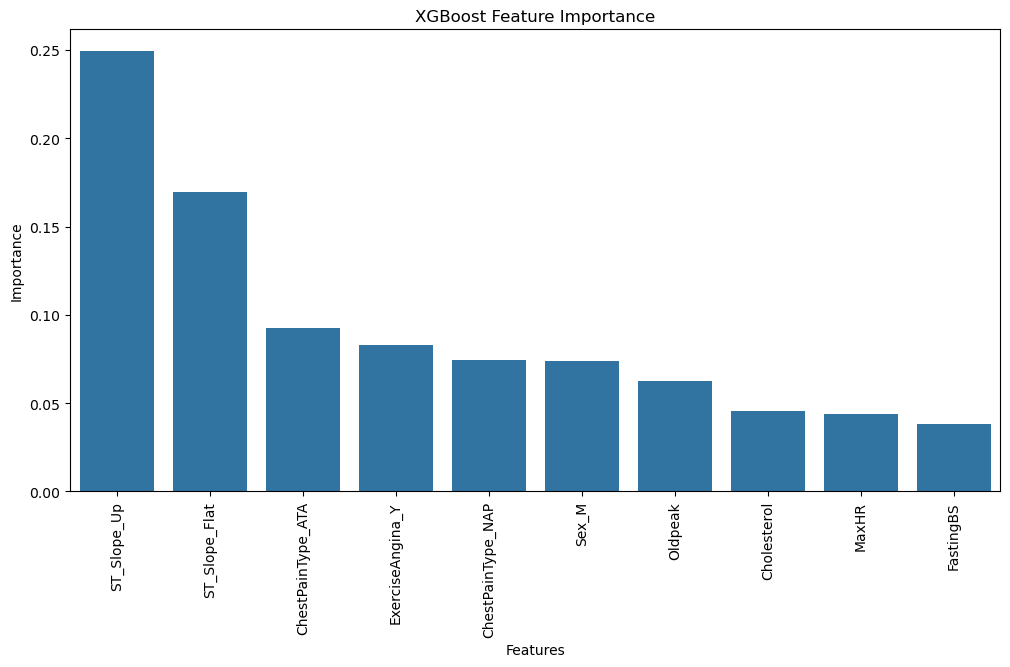

In [58]:
plt.figure(figsize=(12,6))
sns.barplot(x=xgb_features['Features'], y=xgb_features['Importance'])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("XGBoost Feature Importance")

## ADA Boost

In [59]:
base_learner = DecisionTreeClassifier(max_depth=3)

In [60]:
ada=AdaBoostClassifier(
    estimator=base_learner,
    n_estimators=50,
    learning_rate=0.1,
    random_state=42)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Classification Report
              precision    recall  f1-score   support

           0       0.89      0.88      0.88        82
           1       0.90      0.91      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.89      0.90       184
weighted avg       0.90      0.90      0.90       184



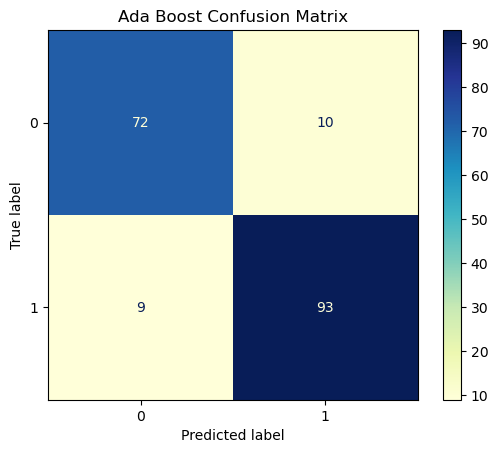

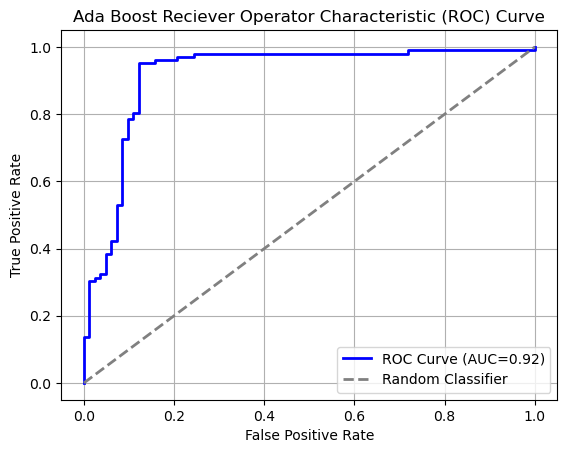

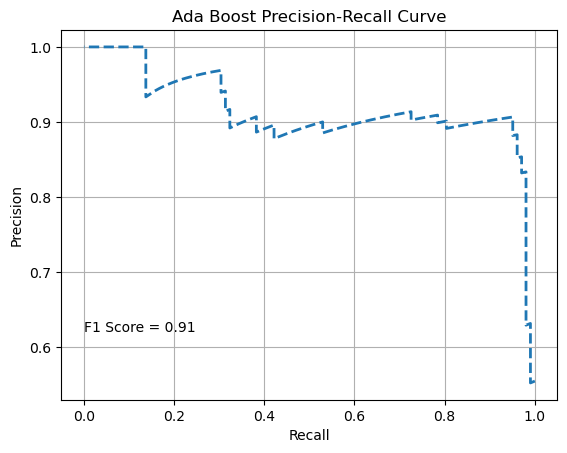

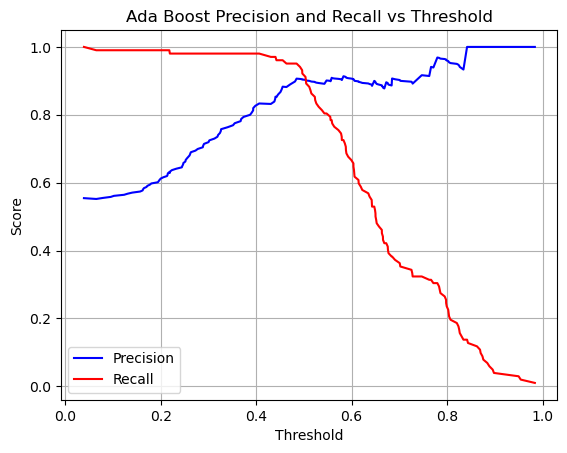

In [61]:
ada_boost = model_build_eval(ada, "Ada Boost")

In [62]:
ada_boost.feature_importances_

array([0.04534795, 0.10577061, 0.16020269, 0.12769701, 0.1778765 ,
       0.01279227, 0.05108436, 0.01533921, 0.02000021, 0.00210433,
       0.04270786, 0.11005962, 0.05688809, 0.05669658, 0.01543271])

In [63]:
ada_features = pd.DataFrame({
    'Features': X_train_final.columns,
    'Importance': ada_boost.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)
ada_features

,Features,Importance
4,RestingBP,0.177876
2,MaxHR,0.160203
3,Oldpeak,0.127697
11,ST_Slope_Up,0.110060
1,Cholesterol,0.105771
12,Sex_M,0.056888
13,ExerciseAngina_Y,0.056697
6,ChestPainType_NAP,0.051084
0,Age,0.045348
10,ST_Slope_Flat,0.042708


Text(0.5, 1.0, 'XGBoost Feature Importance')

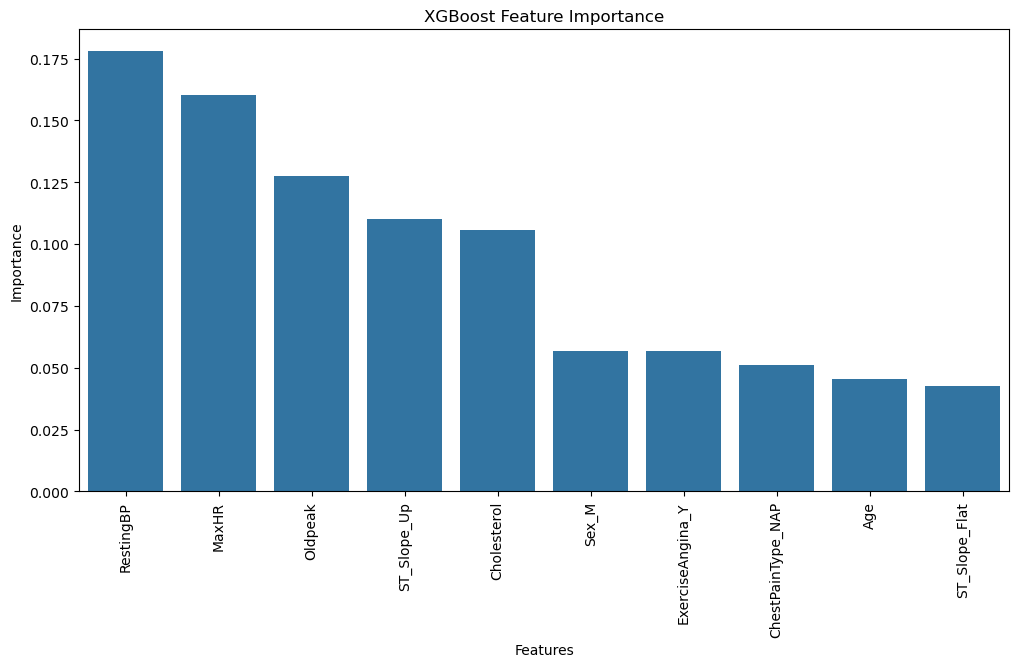

In [64]:

plt.figure(figsize=(12,6))
sns.barplot(x=ada_features['Features'], y=ada_features['Importance'])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("XGBoost Feature Importance")